## Importing performance data
Data, initial cleaning, converting data into dictionary (combined_data_), datafram with dropped kernel name for analysis (df2), and normalized data (X) to be used in later analysis

In [1]:
# Load libraries
import numpy as np
from keras.layers import Input,Dense
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import pandas as pd
import sys
import os
import glob
import csv
import os.path

# Step 1 - Process Data:

save_fname = "saved_data"
if os.path.isfile(save_fname+".npy"):
    print("Loading saved X data.")
    X = np.load(save_fname+".npy")

else:
    #calculating number of kernels total
    kernel_count = 0
    total_kernels = []
    combined_data_ = {}
    target_kernels = []
    metric_targets = []
    all_sig_metrics = []
    for filen_ in glob.glob("/Users/yzamora/Desktop/all_data/*.csv"):
        filen = os.path.basename(filen_)
        filen_split = filen.split('.')[0].split('_')
        bench_name = filen_split[1]
        architecture = filen_split[0]
        unique_spec = filen_split[2]
        key_root = bench_name
        levels = ["Idle", "Low","High", "Max"]
        bw_units = ["GB", "MB", "KB" ,"0B"]

        # Now open the file and look for the data
        with open(filen_ ,'r') as file_handle:

            data_found = False
            ncols = 1
            fdata = csv.reader(file_handle)
            index_lookup = {}
            for line_split in fdata:

                lsplt = (len(line_split) > 0)

                if data_found:

                    if lsplt and len(line_split) == ncols:

                        # Read in desired value for the current metric
                        target_index = index_lookup['Avg']; value = 0
                        metric_name = line_split[index_lookup['Metric Name']]
                        if line_split[target_index].isdecimal():
                            if line_split[target_index]!= '0':

                                all_sig_metrics.append(metric_name)
                                value = int(line_split[ target_index ])

                            # Labeled with percentage
                        elif "%" == line_split[target_index][-1]:
                            #print ("percentage loop")
                            all_sig_metrics.append(metric_name)
                            value = float(line_split[ target_index ][0:7]) / 100.0

                        # Labeled with bandwidth units
                        elif line_split[ target_index ][-4:-2] in bw_units:
                            # Just take the first
                            units = line_split[ target_index ][-4:-2]
                            all_sig_metrics.append(metric_name)
                            mfact = 1.0
                            if   units == "KB": mfact = 1024
                            elif units == "MB": mfact = 1024*1024
                            elif units == "GB": mfact = 1024*1024*1024
                            elif units == "0B":  mfact = 1
                            value = float(line_split[ target_index ][0:7]) * mfact

                        # idle, low, max
                        elif line_split[ target_index ][-1] == ")":
                            #print ("low")
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index].split('(')[1].split(")")[0])

                        # otherwise, float
                        else:
                            value = float(line_split[ target_index ])

                         # Parse name of kernel
                        kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                        if not(kernel_name in total_kernels):
                            total_kernels.append(kernel_name)
                            kernel_count += 1

                        # Define kernel-specific key
                        key = key_root + architecture + "_" + unique_spec + "_" + kernel_name

                        # Initialize dict for this key, if it is new
                        if not (key in combined_data_):
                            combined_data_ [ key ] = {}
                        if not (kernel_name in target_kernels):
                            target_kernels.append(kernel_name)

                        # Store value for the metric being read right now
                        combined_data_[key][ metric_name ] = value
                        combined_data_[key]["kernelname"] = kernel_name

                    else:
                        data_found = False


                elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                    # Set flag that we are at the data:
                    data_found = True
                    # Set number of columns in table:
                    ncols = len(line_split)
                    # Generate an index lookup table:
                    idx = 0
                    for term in line_split:
                        index_lookup[term] = idx
                        idx += 1
    #from sklearn.preprocessing import scale
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    df = pd.DataFrame.from_dict(combined_data_,orient='index')
    df = df.dropna(axis=1,how='any')
    df2 = df.drop(columns=['kernelname'])
    df3 = df2.drop(columns=['ipc'])
    data_no_ipc = df3.values
    data = df2.values #scale(df2.values)
    #X = StandardScaler().fit_transform(data)
    X = MinMaxScaler().fit_transform(data)
    X_no_ipc = MinMaxScaler().fit_transform(data_no_ipc)
    #X=X.astype('float32')/float(X.max())

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Performance data separated in respective dictionaries
V100, P100, and combined_data_

In [2]:
v100_only = {}
p100_only = {}
for key, value in combined_data_.items():
    if 'V100' in key:
        v100_only[key] = value
    if 'P100' in key:
        p100_only[key] = value

def change_X_norm(combined_data_):
    df = pd.DataFrame.from_dict(combined_data_,orient='index')
    df = df.dropna(axis=1,how='any')
    df2 = df.drop(columns=['kernelname'])
    df3 = df2.drop(columns=['ipc'])
    data_no_ipc = df3.values
    data = df2.values #scale(df2.values)
    #X = StandardScaler().fit_transform(data)
    X = MinMaxScaler().fit_transform(data)
    X_no_ipc = MinMaxScaler().fit_transform(data_no_ipc)
    #X=X.astype('float32')/float(X.max())
    Y = df['ipc']
    return X, X_no_ipc, Y

v100_X,v100_x_noipc, V100_Y = change_X_norm(v100_only)
p100_X,p100_x_noipc, P100_Y = change_X_norm(p100_only)

## Keys for p100 and v100

In [3]:
p100_keys = p100_only['backpropP100_-80176_bpnn_layerforward_CUDA'].keys()
v100_keys = v100_only['backpropV100_-12672_bpnn_layerforward_CUDA'].keys()

print (len(p100_keys))
print (len(v100_keys))

# Removing metrics from V100 dataset that are not the same
#for k in p100_keys:
    #if 

161
177


## Removing metrics from V100 dataset that are not the same

In [4]:
v100_keys = v100_only['backpropV100_-12672_bpnn_layerforward_CUDA'].keys()
df_v = pd.DataFrame.from_dict(v100_only,orient='index')
df_v = df_v.dropna (axis=1,how='any')
labels = df_v['kernelname'].tolist()
df3_v = df_v
columns = list(df_v.columns.values)
#benchmarks = df3_v['benchmark_name']
indices = df3_v.index
for metric in columns:
    if not metric in p100_keys:
        df3_v = df3_v.drop(columns=[metric])

## Scaling v100 data --> V_limited

In [5]:
from sklearn.preprocessing import scale
df3_v = df3_v.drop(columns = ['kernelname'])
df3v_values = df3_v.values
data3v = scale(df3v_values)        
n_samples, n_features = data3v.shape
print(n_samples, n_features)
V_limited = data3v
from sklearn.preprocessing import StandardScaler
V_limited = StandardScaler().fit_transform(V_limited)

2783 117


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## STATS: Mean, variance, standard Dev

In [6]:
def get_stats(group):
    return {'std': group.std(), 'mean': group.mean()}


###
dfv100 = pd.DataFrame.from_dict(v100_only,orient='index')
dfv100 = dfv100.dropna(axis=1,how='any')

#kgb = dfv100.groupby(['kernelname']).describe()
#kgb = dfv100['ipc'].groupby(dfv100['kernelname']).describe()


frames = []
kernel_target = 'kmeansPoint'
for key in dfv100.keys():
    #print(key)
    if key == 'kernelname': continue
    kgb = dfv100[key].groupby(dfv100['kernelname']).apply(get_stats).unstack().reset_index()
    select = kgb.loc[ kgb.kernelname == kernel_target]
    select['metric'] = key
    select['std_normalized'] = select['std'] / select['mean']
    frames.append( select )

result = pd.concat(frames)
result = result.drop(columns=['kernelname'])
result.dropna(axis=0,how='any')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mean,std,metric,std_normalized
13,4.083957e+03,1.158947e+03,inst_per_warp,2.837803e-01
13,9.988797e-01,2.268148e-03,branch_efficiency,2.270692e-03
13,9.706401e-01,6.551177e-02,warp_execution_efficiency,6.749337e-02
13,9.254217e-01,6.232622e-02,warp_nonpred_execution_efficiency,6.734899e-02
13,3.861600e-03,2.618837e-03,inst_replay_overhead,6.781741e-01
13,3.893709e+00,2.353413e-01,gst_transactions_per_request,6.044143e-02
13,5.555510e+04,1.187736e+05,gst_transactions,2.137943e+00
13,5.000000e+00,0.000000e+00,sysmem_write_transactions,0.000000e+00
13,6.813854e+06,1.475537e+07,l2_read_transactions,2.165495e+00
13,6.130490e+04,1.238394e+05,l2_write_transactions,2.020057e+00


In [7]:
result.dropna(axis=0,how='any').reset_index().drop(columns=['index'])

,mean,std,metric,std_normalized
0,4.083957e+03,1.158947e+03,inst_per_warp,2.837803e-01
1,9.988797e-01,2.268148e-03,branch_efficiency,2.270692e-03
2,9.706401e-01,6.551177e-02,warp_execution_efficiency,6.749337e-02
3,9.254217e-01,6.232622e-02,warp_nonpred_execution_efficiency,6.734899e-02
4,3.861600e-03,2.618837e-03,inst_replay_overhead,6.781741e-01
5,3.893709e+00,2.353413e-01,gst_transactions_per_request,6.044143e-02
6,5.555510e+04,1.187736e+05,gst_transactions,2.137943e+00
7,5.000000e+00,0.000000e+00,sysmem_write_transactions,0.000000e+00
8,6.813854e+06,1.475537e+07,l2_read_transactions,2.165495e+00
9,6.130490e+04,1.238394e+05,l2_write_transactions,2.020057e+00


## Data Clustering

In [8]:
## TODO: Cluster applications

## Data information 

In [9]:
print("There are %i total data points." % len(X_no_ipc))
print("There are %i features." % len(X[0]))
print("There are %i total kernels tested." % kernel_count)
print("There is %i V100 data points and %i P100 data points."% (len(v100_x_noipc), len(p100_x_noipc)))

print("\nList of all kernels:\n", total_kernels)
# TODO: What application does kernel and kernel 2 belong to?

There are 16649 total data points.
There are 117 features.
There are 38 total kernels tested.
There is 2783 V100 data points and 13866 P100 data points.

List of all kernels:
 ['bpnn_layerforward_CUDA', 'bpnn_adjust_weights_cuda', 'srad_cuda_1', 'srad_cuda_2', 'volta_sgemm_128x64_nn', 'mergeSortFirst', 'mergepack', 'histogram1024Kernel', 'bucketsort', 'mergeSortPass', 'bucketprefixoffset', 'bucketcount', 'compress', 'reduce', 'srad2', 'extract', 'prepare', 'srad', 'dilate_kernel', 'IMGVF_kernel', 'GICOV_kernel', 'sgemm_128x128x8_NN_vec', 'Fan2', 'Fan1', 'invert_mapping', 'kmeansPoint', 'sgemm_32x32x32_NN_vec', 'volta_sgemm_32x32_sliced1x4_nn', 'set_array', 'STREAM_Triad', 'STREAM_Scale', 'STREAM_Copy', 'STREAM_Add', 'maxwell_sgemm_128x64_nn', 'volta_sgemm_64x32_sliced1x4_nn', 'volta_sgemm_128x128_nn', 'Kernel', 'Kernel2']


## Listing Correlation of features with respect to IPC

In [10]:
## TODO: GET IPS

In [11]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

np_scaled = min_max_scaler.fit_transform(df2)
df_normalized = pd.DataFrame(np_scaled)

plt.matshow(df_normalized.corr())
df_normalized.dropna(how='any')

correlation = (df2.corr()["ipc"])
print(correlation.abs().sort_values(ascending=False))

ipc                                      1.000000
issue_slot_utilization                   0.981840
issued_ipc                               0.977528
single_precision_fu_utilization          0.953891
stall_other                              0.915563
shared_utilization                       0.870216
eligible_warps_per_cycle                 0.844506
shared_store_throughput                  0.784822
stall_memory_dependency                  0.766523
shared_efficiency                        0.745785
shared_load_throughput                   0.732786
special_fu_utilization                   0.729580
stall_sync                               0.707726
global_hit_rate                          0.652870
ldst_fu_utilization                      0.651366
flop_dp_efficiency                       0.575539
warp_nonpred_execution_efficiency        0.546556
double_precision_fu_utilization          0.531183
shared_store_transactions_per_request    0.514671
flop_count_dp_add                        0.492520


## Obtaining Y Vector

In [21]:
Y = df['ipc']

## Running and comparing through 4 different machine learning models
Logisting Regression, Bayesian Ridge, Random Forest, K-Nearest Neighbors

In [22]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.gaussian_process.kernels import RBF

# load dataset
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = pandas.read_csv(url, names=names)
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
# prepare configuration for cross validation test harness
def model_comparison(X,Y,data_name):
    seed = 7
    # prepare models
    models = []
    #models.append(('LR', LogisticRegression()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    #models.append(('CART', DecisionTreeClassifier()))
    #models.append(('NB', GaussianNB()))
    models.append(('BR', BayesianRidge(compute_score=True)))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('SVM', svm.SVR()))
    models.append(('RF', RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        #cv = KFold(len(y), nfolds)
        #cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="neg_mean_squared_error")
        results.append(cv_results)
        names.append(name)
        msg = "%s: Neg. Mean squared error: %f (+/- %f) " % (name, cv_results.mean(), cv_results.std())
        print(msg)

    print("RMSE values that are <0.5 are considered to give a good predictive model. In this case, Random forest provides the best model.")
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison with ' + data_name)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.savefig(data_name + ".png")
    plt.show()

## Results for combined data

BR: Neg. Mean squared error: -16125958.461389 (+/- 48377875.362577) 
KNN: Neg. Mean squared error: -0.018294 (+/- 0.034699) 
SVM: Neg. Mean squared error: -0.016993 (+/- 0.025377) 
RF: Neg. Mean squared error: -0.043698 (+/- 0.074271) 
RMSE values that are <0.5 are considered to give a good predictive model. In this case, Random forest provides the best model.


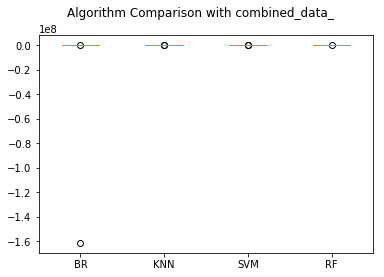

In [23]:
model_comparison(X_no_ipc,Y,'combined_data_')

## Results for V100 data
v100_X,v100_x_noipc, V100_Y 

BR: Neg. Mean squared error: -0.044843 (+/- 0.028451) 
KNN: Neg. Mean squared error: -0.040266 (+/- 0.022808) 
SVM: Neg. Mean squared error: -0.044595 (+/- 0.027112) 
RF: Neg. Mean squared error: -0.034611 (+/- 0.019471) 
RMSE values that are <0.5 are considered to give a good predictive model. In this case, Random forest provides the best model.


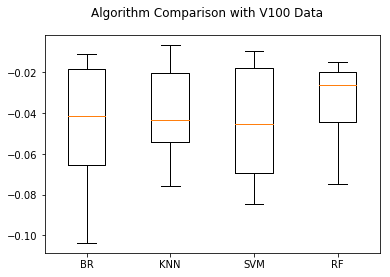

In [24]:
model_comparison(v100_x_noipc, V100_Y, 'V100 Data')

## Results for P100 data
P100_X,P100_x_noipc, P100_Y 

BR: Neg. Mean squared error: -124987.609316 (+/- 374962.826460) 
KNN: Neg. Mean squared error: -0.010912 (+/- 0.029423) 
SVM: Neg. Mean squared error: -0.009529 (+/- 0.019718) 
RF: Neg. Mean squared error: -0.043788 (+/- 0.100274) 
RMSE values that are <0.5 are considered to give a good predictive model. In this case, Random forest provides the best model.


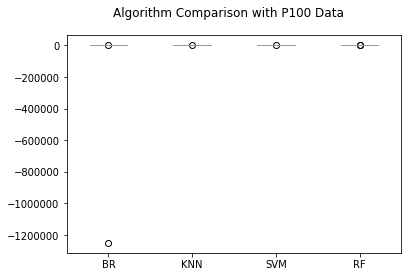

In [25]:
model_comparison(p100_x_noipc, P100_Y, 'P100 Data')

## Further Analysis using Random Forest

In [26]:
# Importing random forest model and libraries
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
import scipy as sp
import pickle as pkl
%matplotlib inline

In [27]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(1,4)),
                     scoring='neg_mean_squared_error',
                    cv=10)

## TODO: Look at trained models and compare models trained with different data

### Training models 

In [28]:
model_combined = model.fit(X_no_ipc,Y)
model_v100 = model.fit(v100_x_noipc, V100_Y)
model_p100 = model.fit(p100_x_noipc, P100_Y)

### Scoring Models

In [29]:
#cross_val_score(model, X, y, scoring='neg_median_absolute_error') 
cross_combined = cross_val_score(model, X_no_ipc, Y, scoring='neg_mean_squared_error') 
cross_P100 = cross_val_score(model, p100_x_noipc, P100_Y, scoring='neg_mean_squared_error') 
cross_V100 = cross_val_score(model, v100_x_noipc, V100_Y, scoring='neg_mean_squared_error') 

print("Cross validation scores for combined data: ", cross_combined)
print("Cross validation scores for P100 data: ", cross_P100)
print("Cross validation scores for V100 data: ", cross_V100)

Cross validation scores for combined data:  [-0.037484   -0.0015836  -0.13762391]
Cross validation scores for P100 data:  [-0.01494956 -0.00071591 -0.0585873 ]
Cross validation scores for V100 data:  [-0.04998475 -0.03401165 -0.07615168]


## Looking at changing different correlation thresholds

In [30]:
# Change threshold
def feature_list(threshold):

    all_met = df3.columns.values
    #print(combined_data_["metrics"])
    #print (correlation[-0.929979])
    needed_features = []
    for m in all_met:
        if correlation[m] >= threshold or correlation[m] <= (-1)*threshold:
            needed_features.append(m) #could be really slow - dynamically allocated memory
    #needed_features.remove("ipc")
    needed_features.remove('issued_ipc')
    needed_features.remove('issue_slot_utilization')
    return (needed_features)
 

In [31]:
def model_results(X, y):
    all_y_test = np.zeros((0,))
    all_y_pred = np.zeros((0,))
    #given options and list of data, returns the indices of training and test sets 
    for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
        # Split off the train and test set
        X_test, y_test = X.iloc[test_inds, :], y[test_inds]
        X_train, y_train = X.iloc[train_inds, :], y[train_inds]

        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append the results
        all_y_test = np.concatenate((all_y_test, y_test))
        #print (all_y_test)
        all_y_pred = np.concatenate((all_y_pred, y_pred))

    print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
    print ("MAE:", np.abs(all_y_test - all_y_pred).mean())
    print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()))

In [32]:
"""
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(1,4)),
                     scoring='neg_mean_squared_error',
                    cv=10)
model.fit(X_no_ipc,Y)
model = model.best_estimator_
feature_importance = list(zip(df2.columns,model.feature_importances_))
correlation = (df.corr()["ipc"])
"""

'\nmodel = GridSearchCV(RandomForestRegressor(n_estimators=100),\n                     param_grid=dict(max_features=range(1,4)),\n                     scoring=\'neg_mean_squared_error\',\n                    cv=10)\nmodel.fit(X_no_ipc,Y)\nmodel = model.best_estimator_\nfeature_importance = list(zip(df2.columns,model.feature_importances_))\ncorrelation = (df.corr()["ipc"])\n'

## Creating model with p100 data - 4/22/2019

In [33]:
model.fit(p100_x_noipc,P100_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(1, 4)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

## Testing model trained on p100 data with v100 data

In [34]:
## First need to drop metrics that are not presented in P100 data
# Keep metrics that are different in v_metrics

## Using model trained with P100 data to predict applications on V100

In [35]:
V100_validate = v100_x_noipc[2782:,:-18]
print(V100_validate.shape)
prediction = model.predict(V100_validate)

(1, 117)


## Training model with V100 data with P100 metrics

In [36]:
print(v100_x_noipc.shape)
print(V_limited.shape)

(2783, 135)
(2783, 117)


## Using V100 data with matching P100 metrics

In [37]:
V100new_validate = V_limited[:,:]
print(V100new_validate.shape)
prediction = model.predict(V100new_validate)

(2783, 117)


In [38]:
print(prediction)

[0.56713521 0.76295793 0.60714889 ... 0.23955711 0.23955711 0.23865166]


In [39]:
print(v100_x_noipc.shape)
print(V100_Y.shape)
#print(V100_Y-prediction)

(2783, 135)
(2783,)


## Plotting results of RF Model trained with P100 data predicting V100 Applications

R: 0.6919462023878459
MAE: 0.2107151670031825 s
RMSE: 0.26692740271679416 s


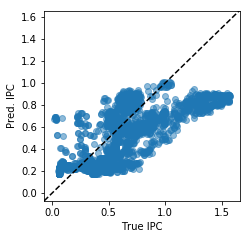

In [40]:
print ("R:",  sp.stats.pearsonr(V100_Y, prediction)[0])
print ("MAE:", np.abs(V100_Y- prediction).mean(), 's')
print ("RMSE:", np.sqrt(np.power(V100_Y- prediction, 2).mean()), 's')


fig, ax = plt.subplots()

# Make the plot
ax.scatter(V100_Y, prediction, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

In [41]:
#TODO: Make feature_list function take in specific data dictionary
#TODO: Make function of obtaining list feature dictionary

In [42]:
import numpy as np
list_fea = {}
count = 0
for i in np.arange(.5,1,0.1):
    i = format(i,'.1f')
    key = "feature_" + str(i)
    #print (key)
    list_fea["feature_" + str(i)] = feature_list(float(i))
    print(len(list_fea["feature_" + str(i)]))
print("Number of features from (+-).5 to (+-).9 correlation values")

16
12
10
4
2
Number of features from (+-).5 to (+-).9 correlation values


In [43]:
#print(list_fea['feature_0.7'])


In [44]:
import pandas as pd
%matplotlib inline

def run_model(cur_features,num_features):   
    df = pd.DataFrame.from_dict(combined_data_,orient="index")
    #display(df.head())
    df = df.dropna()
    X = df[cur_features]
    y = df['ipc']
    print((y))
    #df = df.dropna()

    #print (df)
    print ("X size:", X.shape)
    print ('y size:', y.shape)
    model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                         param_grid=dict(max_features=range(2,num_features)),
                         scoring='neg_mean_squared_error',
                        cv=10)
    model.fit(X,y)
    all_y_test = np.zeros((0,))
    all_y_pred = np.zeros((0,))
    #given options and list of data, returns the indices of training and test sets 
    for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
        # Split off the train and test set
        X_test, y_test = X.iloc[test_inds, :], y[test_inds]
        X_train, y_train = X.iloc[train_inds, :], y[train_inds]

        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append the results
        all_y_test = np.concatenate((all_y_test, y_test))
        #print (all_y_test)
        all_y_pred = np.concatenate((all_y_pred, y_pred))

    print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
    print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
    print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')

    fig, ax = plt.subplots()

    # Make the plot
    ax.scatter(all_y_test, all_y_pred, alpha=0.5)

    # Make it pretty
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())

    ax.set_xlabel('True Time (s)')
    ax.set_ylabel('Pred. Time (s)')

    fig.set_size_inches(3.5, 3.5)

    # Add in the goal line
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

In [45]:
## TODO: Get run models to work? 
## Why is it not getting the same shape for input x and y
df = pd.DataFrame.from_dict(combined_data_,orient="index")
df[list_fea['feature_0.5']]

,warp_nonpred_execution_efficiency,shared_store_transactions_per_request,global_hit_rate,shared_load_throughput,shared_store_throughput,stall_memory_dependency,stall_sync,stall_other,shared_efficiency,eligible_warps_per_cycle,shared_utilization,ldst_fu_utilization,special_fu_utilization,single_precision_fu_utilization,double_precision_fu_utilization,flop_dp_efficiency
backpropP100_-100000_bpnn_adjust_weights_cuda,0.999994,0.000000,0.610572,0.000000e+00,0.000000e+00,0.656743,0.089843,0.142231,0.000000,1.105257,0,1,0,2,1,0.047434
backpropP100_-100000_bpnn_layerforward_CUDA,0.761888,0.696429,0.240006,6.578945e+11,4.138362e+11,0.060660,0.155894,0.603489,0.554455,3.742414,2,4,3,6,0,0.000000
backpropP100_-10000_bpnn_adjust_weights_cuda,0.999948,0.000000,0.609437,0.000000e+00,0.000000e+00,0.371358,0.074840,0.333326,0.000000,2.279254,0,1,0,3,2,0.043993
backpropP100_-10000_bpnn_layerforward_CUDA,0.761888,0.696429,0.240000,4.673504e+11,2.939787e+11,0.001881,0.154155,0.602551,0.554455,3.487984,1,3,3,6,0,0.000000
backpropP100_-100016_bpnn_adjust_weights_cuda,0.999994,0.000000,0.610632,0.000000e+00,0.000000e+00,0.647847,0.088296,0.151583,0.000000,1.109910,0,1,0,2,1,0.048306
backpropP100_-100016_bpnn_layerforward_CUDA,0.761888,0.696429,0.240006,6.583047e+11,4.140950e+11,0.058766,0.158774,0.602430,0.554455,3.720851,2,4,3,6,0,0.000000
backpropP100_-100032_bpnn_adjust_weights_cuda,0.999994,0.000000,0.610794,0.000000e+00,0.000000e+00,0.648730,0.087813,0.152530,0.000000,1.101528,0,1,0,2,1,0.047573
backpropP100_-100032_bpnn_layerforward_CUDA,0.761888,0.696429,0.240012,6.582531e+11,4.140628e+11,0.060356,0.158003,0.604140,0.554455,3.744590,2,4,3,6,0,0.000000
backpropP100_-100048_bpnn_adjust_weights_cuda,0.999994,0.000000,0.610713,0.000000e+00,0.000000e+00,0.642111,0.088483,0.155319,0.000000,1.109192,0,1,0,2,1,0.047407
backpropP100_-100048_bpnn_layerforward_CUDA,0.761888,0.696429,0.240006,6.556622e+11,4.124318e+11,0.060538,0.159211,0.601940,0.554455,3.742023,2,4,3,6,0,0.000000


In [46]:
df_feat05 = df[list_fea['feature_0.5']]

backpropP100_-100000_bpnn_adjust_weights_cuda    0.638858
backpropP100_-100000_bpnn_layerforward_CUDA      1.886349
backpropP100_-10000_bpnn_adjust_weights_cuda     1.105768
backpropP100_-10000_bpnn_layerforward_CUDA       1.730182
backpropP100_-100016_bpnn_adjust_weights_cuda    0.643927
backpropP100_-100016_bpnn_layerforward_CUDA      1.890144
backpropP100_-100032_bpnn_adjust_weights_cuda    0.635611
backpropP100_-100032_bpnn_layerforward_CUDA      1.892993
backpropP100_-100048_bpnn_adjust_weights_cuda    0.634721
backpropP100_-100048_bpnn_layerforward_CUDA      1.889795
backpropP100_-100064_bpnn_adjust_weights_cuda    0.638679
backpropP100_-100064_bpnn_layerforward_CUDA      1.891316
backpropP100_-100080_bpnn_adjust_weights_cuda    0.650493
backpropP100_-100080_bpnn_layerforward_CUDA      1.890775
backpropP100_-100096_bpnn_adjust_weights_cuda    0.632664
backpropP100_-100096_bpnn_layerforward_CUDA      1.887911
backpropP100_-100112_bpnn_adjust_weights_cuda    0.643057
backpropP100_-

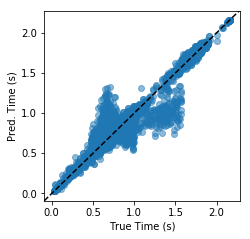

In [49]:
#df = pd.DataFrame.from_dict(combined_data_,orient="index")
#display(df.head())
df5 = df_feat05.dropna()
X = df5
y = df2['ipc']
print((y))
num_features = len(list_fea["feature_0.5"])

#df = df.dropna()

#print (df)
print ("X size:", X.shape)
print ('y size:', y.shape)
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(2,num_features)),
                     scoring='neg_mean_squared_error',
                    cv=10)
model.fit(X,y)
all_y_test = np.zeros((0,))
all_y_pred = np.zeros((0,))
#given options and list of data, returns the indices of training and test sets 
for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
    # Split off the train and test set
    X_test, y_test = X.iloc[test_inds, :], y[test_inds]
    X_train, y_train = X.iloc[train_inds, :], y[train_inds]

    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the results
    all_y_test = np.concatenate((all_y_test, y_test))
    #print (all_y_test)
    all_y_pred = np.concatenate((all_y_pred, y_pred))

print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')

fig, ax = plt.subplots()

# Make the plot
ax.scatter(all_y_test, all_y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True IPC')
ax.set_ylabel('Pred. IPC)')

fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');

In [ ]:
X_validate = v100_x_noipc[1]

In [ ]:
print(len(X_validate))

In [50]:
df = pd.DataFrame.from_dict(combined_data_,orient="index")
X = df[list_fea["feature_0.5"]]
y = df['ipc']
num_features = len(list_fea["feature_0.5"])

model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(2,num_features)),
                     scoring='neg_mean_squared_error',
                    cv=10)
model.fit(X,y)
all_y_test = np.zeros((0,))
all_y_pred = np.zeros((0,))
#given options and list of data, returns the indices of training and test sets 
for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
    # Split off the train and test set
    X_test, y_test = X.iloc[test_inds, :], y[test_inds]
    X_train, y_train = X.iloc[train_inds, :], y[train_inds]

    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the results
    all_y_test = np.concatenate((all_y_test, y_test))
    #print (all_y_test)
    all_y_pred = np.concatenate((all_y_pred, y_pred))

print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')



R: 0.9891970947152195
MAE: 0.0351718424364754 s
RMSE: 0.08974180663378012 s


In [ ]:
df = pd.DataFrame.from_dict(p100_only,orient="index")
X = df[list_fea["feature_0.5"]]
y = df['ipc']
num_features = len(list_fea["feature_0.5"])

model_p100 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(2,num_features)),
                     scoring='neg_mean_squared_error',
                    cv=10)
model_p100.fit(X,y)
all_y_test = np.zeros((0,))
all_y_pred = np.zeros((0,))
#given options and list of data, returns the indices of training and test sets 
for train_inds, test_inds in ShuffleSplit(n_splits=5, test_size=0.1).split(X,y):
    # Split off the train and test set
    X_test, y_test = X.iloc[test_inds, :], y[test_inds]
    X_train, y_train = X.iloc[train_inds, :], y[train_inds]

    # Train the model
    model_p100.fit(X_train, y_train)
    y_pred = model_p100.predict(X_test)

    # Append the results
    all_y_test = np.concatenate((all_y_test, y_test))
    #print (all_y_test)
    all_y_pred = np.concatenate((all_y_pred, y_pred))

print ("R:",  sp.stats.pearsonr(all_y_test, all_y_pred)[0])
print ("MAE:", np.abs(all_y_test - all_y_pred).mean(), 's')
print ("RMSE:", np.sqrt(np.power(all_y_test - all_y_pred, 2).mean()), 's')



In [ ]:
## TODO: Try to use model trained on P100 data to predict V100 performance

In [ ]:
run_model(list_fea["feature_0.5"],len(list_fea["feature_0.5"]))

## Cross validation results for random forest model
Tested on combined data, P100 data, and V100 data